So this is my personal notes using the MNIST dataset (covering some basic type of NN)

In [237]:
#import necessary packages
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset
import numpy as np


In [244]:
#define some global para
BATCH_SIZE = 64
LR = 0.01
EPOCH = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [239]:
#download data
trainset = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True           
)

testset = datasets.MNIST(
    root = 'data',
    train = False,                         
    transform = ToTensor(), 
    download = True            
)

In [168]:
#dataloader
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

After getting the data into loader, I want to see what's a picture is like, so i picked the first one:

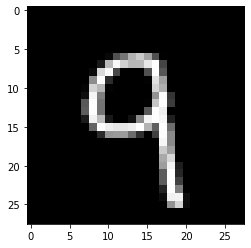

tensor(9)


In [169]:
#get a random picture and have a look
batch_img, batch_label= next(iter(trainloader))
plt.imshow(batch_img[0].squeeze(), cmap="gray")
plt.show()
print(batch_label[0])

And I want to see each item inside the loader:

In [170]:
batch_img.shape
#And see the shape: 64 imgs in a batch, 1 channel, 28 x 28 size

torch.Size([64, 1, 28, 28])

Ok, so we start with a simple neural network first. It is a two-layer linear structure. To fit the 28x28 image inside, we need to flatten it to 1 dimension, and we classify it from then on.

In [171]:
#Try with a neural network with 2 linear layers first, will be used on flattened image set
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super(SimpleNeuralNetwork, self).__init__()
        self.flatten=nn.Flatten()
        self.linear1=nn.Linear(784,256) #can tweak the paras to see if there are better results
        self.linear2=nn.Linear(256,10) #ten categories

    def forward(self, x):
        x = self.flatten(x)
        x= F.relu(self.linear1(x))
        x= F.log_softmax(self.linear2(x))
        return x

In [172]:
#create model
model = SimpleNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=LR)

#training
def train(epoch_num):
  model.train()
  for batch_num,(x_train,y_train) in enumerate(trainloader):
    optimizer.zero_grad()
    #calculate output
    output = model(x_train.to(device))
 
    #calculate loss
    loss = F.nll_loss(output, y_train.to(device))
    
    #backprop
    loss.backward()
    optimizer.step()

def test(epoch_num):
  correct = 0
  with torch.no_grad():
    for x_test, y_test in testloader:
      output = model(x_test.to(device))
      prediction = output.data.max(1, keepdim=True)[1]
      correct += prediction.eq(y_test.to(device).data.view_as(prediction)).sum()
  print("Test: "+ str(epoch_num) + " Accuracy: "+str(correct/len(testloader.dataset)))
  
for i in range(EPOCH):
  train(i)
  test(i)

C:\Users\charl\AppData\Local\Temp\ipykernel_12904\3852790194.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x= F.log_softmax(self.linear2(x))


Test: 0 Accuracy: tensor(0.8667, device='cuda:0')
Test: 1 Accuracy: tensor(0.8943, device='cuda:0')
Test: 2 Accuracy: tensor(0.9024, device='cuda:0')
Test: 3 Accuracy: tensor(0.9108, device='cuda:0')
Test: 4 Accuracy: tensor(0.9155, device='cuda:0')
Test: 5 Accuracy: tensor(0.9208, device='cuda:0')
Test: 6 Accuracy: tensor(0.9242, device='cuda:0')
Test: 7 Accuracy: tensor(0.9270, device='cuda:0')
Test: 8 Accuracy: tensor(0.9301, device='cuda:0')
Test: 9 Accuracy: tensor(0.9326, device='cuda:0')


Looks like the accuracy is pretty good, at around 90% for only 10 epochs (sorry it takes quite a while to run for more epochs, so I'll only use 10)

Now let's see if we want to retain the spatial structure, i.e. know the position of pixels in a 2d way instead of simple flattening.

We will use a CNN, and I build a rough one with 2 conv layers, and we extract the "key info" into a flattened tensor and pass it to a linear layer for it to categorize into 10 categories.


In [173]:
#It seems flattened MNIST is pretty good, but what if we want to retain spatial info?
#So we define CNN

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.flatten=nn.Flatten()
        self.conv1 = nn.Conv2d(1,5, kernel_size=5) #assume in 1 channel, out 5 channel, and it is a 5,5 square filter
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5)
        self.convdrop = nn.Dropout2d()
        self.linear1=nn.Linear(160,10)#flattened shape should be of length 160

    def forward(self, x):
        x= F.relu(F.max_pool2d(self.conv1(x),2))#using max pool because it is kinda the 'brightest' spot
        x= F.relu(F.max_pool2d(self.convdrop(self.conv2(x)),2))
        x = self.flatten(x) #need to flatten it to pass into the linear layer
        x=F.relu(self.linear1(x))
        return F.log_softmax(x)

In [174]:
model_cnn = CNN().to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(),lr=LR)

#training
def train(epoch_num):
  model_cnn.train()
  for batch_num,(x_train,y_train) in enumerate(trainloader):
    
    optimizer.zero_grad()
    #calculate output
    output = model_cnn(x_train.to(device))
 
    #calculate loss
    loss = F.nll_loss(output, y_train.to(device))
   
    #backprop
    loss.backward()
    optimizer.step()
    
    #train acc
    if batch_num % 100 == 0:
      print("Train batch : "+ str(batch_num) + " Loss: "+str(loss.item()))

def test(epoch_num):
  model_cnn.eval()
  correct = 0
  with torch.no_grad():
    for x_test, y_test in testloader:
      output = model_cnn(x_test.to(device))
      prediction = output.data.max(1, keepdim=True)[1]
      correct += prediction.eq(y_test.to(device).data.view_as(prediction)).sum()
  print("Test: "+ str(epoch_num) + " Accuracy: "+str(correct/len(testloader.dataset)))
  
for i in range(EPOCH):
  train(i)
  test(i)

C:\Users\charl\AppData\Local\Temp\ipykernel_12904\2296799989.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train batch : 0 Loss: 2.2981276512145996
Train batch : 100 Loss: 2.279198408126831
Train batch : 200 Loss: 2.265749931335449
Train batch : 300 Loss: 2.2190499305725098
Train batch : 400 Loss: 2.0052578449249268
Train batch : 500 Loss: 1.4925092458724976
Train batch : 600 Loss: 1.493431568145752
Train batch : 700 Loss: 1.1589534282684326
Train batch : 800 Loss: 1.0297698974609375
Train batch : 900 Loss: 1.0617928504943848
Test: 0 Accuracy: tensor(0.7082, device='cuda:0')
Train batch : 0 Loss: 1.0730575323104858
Train batch : 100 Loss: 1.25726318359375
Train batch : 200 Loss: 1.0652964115142822
Train batch : 300 Loss: 1.2147197723388672
Train batch : 400 Loss: 0.7091343998908997
Train batch : 500 Loss: 0.694392204284668
Train batch : 600 Loss: 0.5129460692405701
Train batch : 700 Loss: 0.44637537002563477
Train batch : 800 Loss: 0.5419738292694092
Train batch : 900 Loss: 0.4966060221195221
Test: 1 Accuracy: tensor(0.8965, device='cuda:0')
Train batch : 0 Loss: 0.4919413924217224
Train ba

Results look good too. of course, we can change the parameters to get better accuracy, but for now we'll leave it like that and try our next model, GAN.

Since GAN is about generating an image, perhaps we should use image for 1 number instead. Since I like number 5 I'll just pick that.

In [240]:
indices = [idx for idx, target in enumerate(trainset.targets) if target == 5]
trainloader_5 = torch.utils.data.DataLoader(Subset(trainset, indices),
                                         batch_size=BATCH_SIZE, 
                                         drop_last=True)

indices = [idx for idx, target in enumerate(testset.targets) if target == 5]
testloader_5 = torch.utils.data.DataLoader(Subset(trainset, indices),
                                         batch_size=BATCH_SIZE, 
                                         drop_last=True)

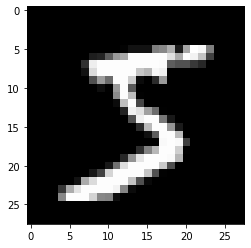

In [203]:
#get a random picture and have a look
batch_img, batch_label = next(iter(trainloader_5))
plt.imshow(batch_img[0].squeeze(), cmap="gray")
plt.show()

Discriminator takes in the whole 784 numbers and use 2 layers to divide into 2 categories. 

In [241]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten=nn.Flatten()
        self.linear1=nn.Linear(784,256) #can tweak the paras to see if there are better results
        self.linear2=nn.Linear(256,2) #ten categories

    def forward(self, x):
        x=self.flatten(x)
        x= F.relu(self.linear1(x))
        x= F.log_softmax(self.linear2(x))
        return x

Gnerator takes in random noise to get the 784 numbers.

In [266]:
class Generator (nn.Module):
    def __init__(self, inpute_size):
        super(Generator, self).__init__()
        self.linear1=nn.Linear(input_size,256) #can tweak the paras to see if there are better results
        self.linear2=nn.Linear(256,784) #ten categories

    def forward(self, x):
        x= F.relu(self.linear1(x))
        x= torch.tanh(self.linear2(x))
        return x

I created some hyper parameter below. The 100 is the input noise size, and epoch is changed to 100 to get a better picture.

In [267]:
#hyper para
input_size = 100
EPOCH = 100

In [268]:
#create model
D=Discriminator()
G=Generator(input_size)

#define optim
D_optimizer = torch.optim.SGD(D.parameters(), LR)
G_optimizer = torch.optim.SGD(G.parameters(), LR)

def train():
  D.train()
  G.train()
  for item in trainloader_5:
    
    #train D first
    D_optimizer.zero_grad()
    D_real = D(item[0])
    D_real_loss = F.nll_loss(D_real, torch.from_numpy(np.ones(BATCH_SIZE)).type(torch. int64))
    
    #get some random noise
    z = np.random.uniform(-1, 1, size=(BATCH_SIZE, input_size))
    z = torch.from_numpy(z).float()
    
    fake_images = G(z)
        
    # Compute the discriminator losses on fake images        
    D_fake = D(fake_images)
    D_fake_loss = F.nll_loss(D_fake, torch.from_numpy(np.zeros(BATCH_SIZE)).type(torch. int64))
    
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    
    #train G next
    G_optimizer.zero_grad()
    z = np.random.uniform(-1, 1, size=(BATCH_SIZE, input_size))
    z = torch.from_numpy(z).float()
    fake_images = G(z)
    D_fake = D(fake_images)
    G_loss = F.nll_loss(D_fake, torch.from_numpy(np.ones(BATCH_SIZE)).type(torch. int64))
    G_loss.backward()
    G_optimizer.step()
  
  print("G: "+str(G_loss.item())+" D: "+str(D_loss.item()))

for i in range(EPOCH):
  train()
  G.eval() # eval mode for generating samples
  G.train()
  


    

C:\Users\charl\AppData\Local\Temp\ipykernel_12904\1753854258.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x= F.log_softmax(self.linear2(x))


G: 1.080370545387268 D: 0.4720352292060852
G: 0.812414824962616 D: 0.7685874104499817
G: 0.829698920249939 D: 0.8583457469940186
G: 0.8324255347251892 D: 0.9721237421035767
G: 0.9152796864509583 D: 0.9770674109458923
G: 1.1318325996398926 D: 0.7996824979782104
G: 1.4470990896224976 D: 0.5644732713699341
G: 1.7209727764129639 D: 0.37917831540107727
G: 1.7703897953033447 D: 0.3382510542869568
G: 1.933081865310669 D: 0.3372156620025635
G: 1.8876174688339233 D: 0.38473933935165405
G: 1.7420073747634888 D: 0.41964107751846313
G: 1.575890064239502 D: 0.7849604487419128
G: 1.521875023841858 D: 0.5306041836738586
G: 1.6665974855422974 D: 0.47660893201828003
G: 1.6999620199203491 D: 0.4668906033039093
G: 1.6899415254592896 D: 0.3963555097579956
G: 1.8730520009994507 D: 0.4167863130569458
G: 1.8741395473480225 D: 0.4457424283027649
G: 2.3164610862731934 D: 0.323199987411499
G: 1.7308251857757568 D: 0.7450475692749023
G: 1.6813454627990723 D: 0.669833242893219
G: 1.8546912670135498 D: 0.511181116

And below is the result (I picked the first one generated)! As we can see it is not perfect yet with the kinda grey background, but the '5' shape is rather distinct. With more epochs and some tuning of the architecture, it is possible to achieve a better outcome.

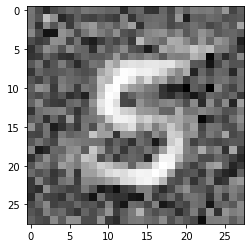

In [269]:
input =  np.random.uniform(-1, 1, size=(BATCH_SIZE, input_size))
input = torch.from_numpy(input).float()
img_set = G(input)
img=img_set[0]
img=img.view(28,28).detach().numpy()
plt.imshow(img, cmap="gray")
plt.show()